<a href="https://colab.research.google.com/github/Rexoes/-dev-3/blob/main/AUE_PSO_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os

save_dir = '/content/drive/My Drive/PSO_ANN_Results'
os.makedirs(save_dir, exist_ok=True)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [17]:
# Veri Seti Oluşturma
# X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)
X, y = make_classification(n_samples=3000, n_features=10, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# StandardScaler kullanarak veri setini ölçeklendirme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Sadece eğitim verisiyle ölçekleme işlemini öğrenme (fit)
X_test = scaler.transform(X_test)        # Eğitim verisiyle öğrenilen ölçekleme ile test verisini dönüştürme

# Numpy kullanarak sınıf dağılımını öğrenme
unique, counts = np.unique(y, return_counts=True)
class_distribution_np = dict(zip(unique, counts))
print("Sınıf Dağılımı (Numpy):", class_distribution_np)

Sınıf Dağılımı (Numpy): {0: 1494, 1: 1506}


In [18]:
# Basit Yapay Sinir Ağı Modeli Tanımlama
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_model2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_model3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01), input_shape=(10,)),
        tf.keras.layers.Dropout(0.3),  # %30 Dropout
        tf.keras.layers.Dense(32, activation='relu'),  # Düzenleme yok
        tf.keras.layers.Dropout(0.3),  # %30 Dropout
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# İkinci Model

# Batch Normalization;
# --------------------
# Her bir batch (küme) boyunca verileri normalize eder. Bu, her bir batch içindeki özelliklerin ortalama sıfır ve standart sapması bire eşit olacak şekilde ölçeklenmesi anlamına gelir.
# -> Eğitim sırasında daha stabil bir öğrenme süreci sağlar ve modelin daha hızlı öğrenmesine yardımcı olur.
# -> Düşük öğrenme oranlarında bile eğitimi hızlandırır ve farklı feature’ların daha dengeli bir şekilde öğrenilmesine olanak tanır.
# -> Overfitting’i azaltır ve derin ağlarda katman sayısını artırmaya yardımcı olur.

# Dropout Katmanı;
# ----------------
# Dropout, her eğitim adımında bu katmandaki nöronların %30’unu rastgele olarak devre dışı bırakır. Eğitim sırasında, devre dışı bırakılan nöronlar ağırlık güncellemelerine katılmaz.
# Amaç olarak, Overfitting’i önlemek. Modelin belirli nöronlara aşırı bağımlılık geliştirmesini engeller ve modelin daha genel özellikler öğrenmesine katkı sağlar.


def create_advanced_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu', input_shape=(10,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [19]:
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def reshape_weights(flat_weights):
    weights = []
    index = 0
    for shape in weight_shapes:
        size = np.prod(shape)
        weights.append(flat_weights[index:index + size].reshape(shape))
        index += size
    return weights

In [20]:
# PSO Parametreleri ve Başlangıç Değerleri
# num_particles = 30
num_particles = 50
num_iterations = 50
#c1, c2 = 1.5, 1.5
#w = 0.5

initial_w = 0.9
final_w = 0.4

# Öğrenme faktörlerinin başlangıç ve bitiş değerleri
c1_start, c1_end = 2.5, 0.5
c2_start, c2_end = 0.5, 2.5

# Dinamik Atalet eklenebilir!
# w = 0.9 - (0.9 - 0.4) * (iteration / num_iterations)  # Dinamik atalet
#Adaptif PSO ile w, c1 ve c2 parametrelerini dinamik olarak değiştirilebilir!

# Ağırlık ve Biasları Düzleştirme Fonksiyonları
# model = create_model()
model = create_model()
model.summary()
initial_weights = model.get_weights()
weight_shapes = [w.shape for w in initial_weights]
num_weights = sum([np.prod(shape) for shape in weight_shapes])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Parçacık Pozisyonları ve Hızları
positions = np.random.randn(num_particles, num_weights)
velocities = np.random.randn(num_particles, num_weights)
personal_best_positions = positions.copy()
personal_best_scores = np.full(num_particles, np.inf)
global_best_position = None
global_best_score = np.inf

In [22]:
# Global en iyi skorların kaydedilmesi
global_best_scores = []

for iteration in range(num_iterations):
    # Dinamik olarak azalan atalet katsayısı
    w = initial_w - (iteration / num_iterations) * (initial_w - final_w)

    # Dinamik c1 ve c2 değerleri
    c1 = c1_start - (iteration / num_iterations) * (c1_start - c1_end)
    c2 = c2_start + (iteration / num_iterations) * (c2_end - c2_start)

    for i in range(num_particles):
        # Parçacığın ağırlıklarını modele uygula
        model.set_weights(reshape_weights(positions[i]))

        # Performansı değerlendirmek için ileri yayılım kullanın (model tahminlerini hesaplayın)
        y_pred = (model.predict(X_train) > 0.5).astype(int).flatten()
        accuracy = accuracy_score(y_train, y_pred)
        score = 1 - accuracy  # Düşük skor daha iyi performansı ifade eder

        # Kişisel ve global en iyi skorları güncelle
        if score < personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = positions[i].copy()
        if score < global_best_score:
            global_best_score = score
            global_best_position = positions[i].copy()

    global_best_scores.append(global_best_score)

    # Hız ve pozisyonları güncelleme
    for i in range(num_particles):
        r1, r2 = np.random.rand(), np.random.rand()  # Rastgele sayı
        velocities[i] = (
            w * velocities[i] +
            c1 * r1 * (personal_best_positions[i] - positions[i]) +
            c2 * r2 * (global_best_position - positions[i])
        )
        positions[i] += velocities[i]  # Yeni pozisyonları güncelle

    print(f"Iteration {iteration + 1}/{num_iterations}, Best Accuracy: {1 - global_best_score}, Dynamic W: {w}, c1: {c1}, c2: {c2}")

print("PSO Sonrası En İyi Model Doğruluğu:", 1 - global_best_score)

# En iyi pozisyonu (global_best_position) nihai modelde kullanarak test doğruluğunu ölçme
model.set_weights(reshape_weights(global_best_position))
y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print("PSO ile Optimize Edilmiş Model Test Doğruluğu:", accuracy_score(y_test, y_test_pred))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/6

In [23]:
# Model Kaydetme!

# PSO algoritması çalıştırıldıktan sonra global_best_position ağırlıklarını modele uygulayın
# model = create_model3()  # Modeli yeniden oluşturun veya mevcut modeli kullanın
# model = create_advanced_model2()
# model.set_weights(reshape_weights(global_best_position))  # PSO ile optimize edilen ağırlıkları atayın

# Modeli bir dosyaya kaydedin
#model.save("pso_optimized_ann_model.h5")  # Modeli HDF5 formatında kaydeder

# En iyi pozisyonu modele uygula ve kaydet
#model.set_weights(reshape_weights(global_best_position))
model.save(os.path.join(save_dir, 'pso_optimized_ann_model.h5'))

In [25]:
# Kaydedilen Modeli Yükleme!
model_path = os.path.join(save_dir, 'pso_optimized_ann_model.h5')
loaded_model = tf.keras.models.load_model(model_path)

y_test_pred = (loaded_model.predict(X_test) > 0.5).astype(int).flatten()
print("Yüklenen Model Test Doğruluğu:", accuracy_score(y_test, y_test_pred))

# Yüklenen model ile tahmin yapın
#predictions = loaded_model.predict(X_test)

# Tahmin sonuçlarını incelemek veya değerlendirme yapmak için
#y_pred = (predictions > 0.5).astype(int)  # İkili sınıflandırma için eşik değerini uygulayın
#print("Yüklenen model doğruluğu:", accuracy_score(y_test, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Yüklenen Model Test Doğruluğu: 0.9533333333333334


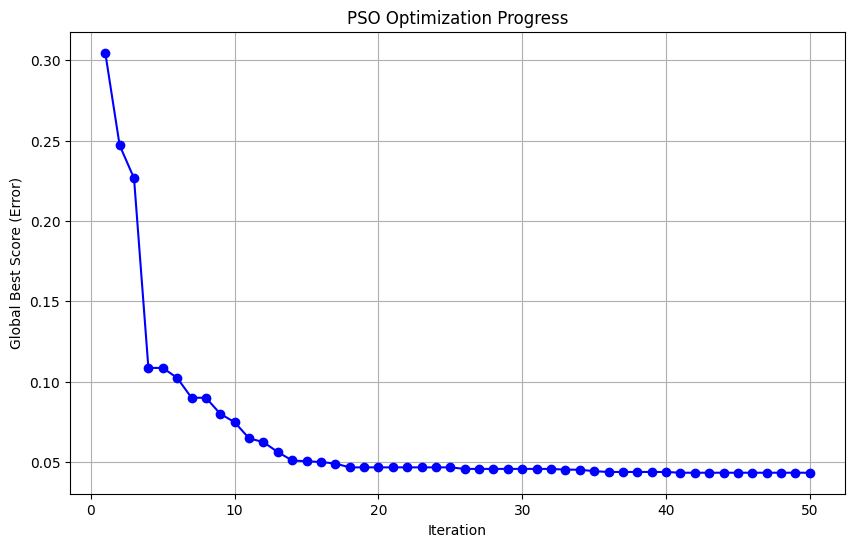

In [26]:
# PSO'nun Yakınsama Sürecini Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), global_best_scores, marker='o', linestyle='-', color='b')
plt.title("PSO Optimization Progress")
plt.xlabel("Iteration")
plt.ylabel("Global Best Score (Error)")
plt.grid(True)
plt.show()

In [27]:
# Çapraz Doğrulama ile PSO ve Standart Eğitim Karşılaştırması
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies_pso = []
accuracies_no_pso = []

for train_idx, test_idx in kfold.split(X):
    # PSO Olmadan Model Eğitimi
    model_no_pso = create_model()
    # model_no_pso = create_advanced_model2()
    model_no_pso.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_no_pso.fit(X[train_idx], y[train_idx], epochs=10, batch_size=64, verbose=0)
    accuracy_no_pso = model_no_pso.evaluate(X[test_idx], y[test_idx], verbose=0)[1]
    accuracies_no_pso.append(accuracy_no_pso)

    # PSO ile Optimize Edilmiş Modelin Doğruluğu (PSO sonrası en iyi ağırlıklarla)
    model_pso = create_model()
    # model_pso = create_advanced_model2()
    model_pso.set_weights(reshape_weights(global_best_position))
    accuracy_pso = accuracy_score(y[test_idx], (model_pso.predict(X[test_idx]) > 0.5).astype(int).flatten())
    accuracies_pso.append(accuracy_pso)

print("Çapraz Doğrulama Sonucu (PSO olmadan):", np.mean(accuracies_no_pso))
print("Çapraz Doğrulama Sonucu (PSO ile):", np.mean(accuracies_pso))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Çapraz Doğrulama Sonucu (PSO olmadan): 0.9690000057220459
Çapraz Doğrulama Sonucu (PSO ile): 0.9470000000000001


In [28]:
# Eğitim ve Test Hatalarını Karşılaştırma
# PSO olmadan modelin eğitim ve test hatası
train_loss_no_pso = model_no_pso.evaluate(X_train, y_train, verbose=0)[0]
test_loss_no_pso = model_no_pso.evaluate(X_test, y_test, verbose=0)[0]

# PSO ile optimize edilen modelin eğitim ve test hatası
train_loss_pso = 1 - accuracy_score(y_train, (model_pso.predict(X_train) > 0.5).astype(int).flatten())
test_loss_pso = global_best_score

print("Eğitim/Test Hatası (PSO olmadan):", train_loss_no_pso, test_loss_no_pso)
print("Eğitim/Test Hatası (PSO ile):", train_loss_pso, test_loss_pso)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Eğitim/Test Hatası (PSO olmadan): 0.14002643525600433 0.13223665952682495
Eğitim/Test Hatası (PSO ile): 0.043333333333333335 0.043333333333333335


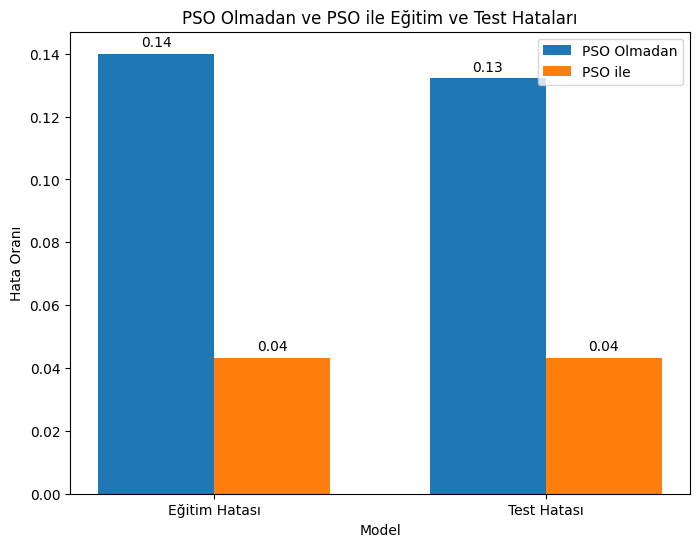

In [29]:
# Eğitim ve Test Hatalarının Grafik Üzerinde Gösterimi
labels = ['Eğitim Hatası', 'Test Hatası']
no_pso_errors = [train_loss_no_pso, test_loss_no_pso]
pso_errors = [train_loss_pso, test_loss_pso]

x = np.arange(len(labels))
width = 0.35  # Bar genişliği

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, no_pso_errors, width, label='PSO Olmadan')
bars2 = ax.bar(x + width/2, pso_errors, width, label='PSO ile')

ax.set_xlabel('Model')
ax.set_ylabel('Hata Oranı')
ax.set_title('PSO Olmadan ve PSO ile Eğitim ve Test Hataları')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Barların üstüne hata oranlarını eklemek
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


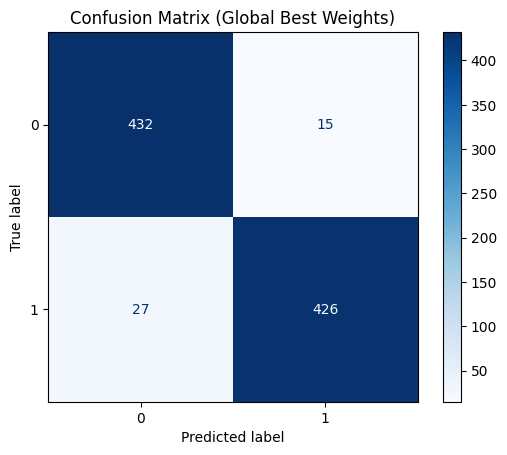

In [30]:
# Test verisi üzerinde tahminler yapalım.
y_pred_prob = model_pso.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Sigmoid çıktısını sınıflara dönüştürme

# Confusion matrix oluşturma
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Confusion matrix görselleştirme
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Global Best Weights)')
plt.show()